# grib reading with xarray

In [1]:
%load_ext jupyter_black

import os
from glob import glob
from typing import Iterable
from collections import namedtuple

import pandas as pd
import numpy as np
from numpy.typing import NDArray
import xarray as xr

In [28]:
import xarray as xr
# "hrrr.t00z.wrfnatf00.grib2"xtrn.wfsgfs0000.gfs_wafs_f30_00
ds:xr.Dataset = xr.load_dataset("data/557ww/GLOBAL.grib2.2022053000.0000", engine="pynio")
ds

<xarray.Dataset>
Dimensions:               (lv_ISBL0: 7, lat_0: 361, lon_0: 720,
                           WCF_probability0: 3, PWAT_probability1: 2,
                           WIND_probability2: 2, GUST_probability3: 4,
                           VWSH_probability4: 2, HGT_probability5: 2,
                           lv_ISBL1: 2, ICI_probability6: 3, lv_ISBL2: 5,
                           TURB_probability7: 3, lv_AMSL3: 7,
                           TURB_probability8: 3, PROCON_probability9: 2)
Coordinates: (12/15)
  * PROCON_probability9   (PROCON_probability9) float32 90.0 100.0
  * TURB_probability8     (TURB_probability8) float32 1.0 2.0 3.0
  * TURB_probability7     (TURB_probability7) float32 4.0 10.0 20.0
  * lv_ISBL2              (lv_ISBL2) float32 2.5e+04 5e+04 ... 8.5e+04 9.25e+04
  * ICI_probability6      (ICI_probability6) float32 58.0 85.0 92.0
  * lv_ISBL1              (lv_ISBL1) float32 5e+04 7e+04
    ...                    ...
  * WIND_probability2     (WIND_probability2) float32 13.0 15.0
  * PWAT_probability1     (PWAT_probability1) float32 25.0 50.0
  * WCF_probability0      (WCF_probability0) float32 244.3 255.4 266.5
  * lat_0                 (lat_0) float32 90.0 89.5 89.0 ... -89.0 -89.5 -90.0
  * lon_0                 (lon_0) float32 0.0 0.5 1.0 1.5 ... 358.5 359.0 359.5
  * lv_ISBL0              (lv_ISBL0) float32 2e+04 2.5e+04 ... 9.25e+04 1e+05
Dimensions without coordinates: lv_AMSL3
Data variables: (12/53)
    TMP_P0_L100_GLL0      (lv_ISBL0, lat_0, lon_0) float32 231.6 231.6 ... 240.7
    TMP_P0_L103_GLL0      (lat_0, lon_0) float32 273.3 273.3 ... 222.1 222.1
    RH_P0_L100_GLL0       (lv_ISBL0, lat_0, lon_0) float32 1.2 1.2 ... 97.96
    RH_P0_L103_GLL0       (lat_0, lon_0) float32 97.22 97.22 ... 100.4 100.4
    UGRD_P0_L100_GLL0     (lv_ISBL0, lat_0, lon_0) float32 15.38 ... -3.034
    UGRD_P0_L103_GLL0     (lat_0, lon_0) float32 -0.3938 -0.3938 ... -2.794
    ...                    ...
    SNFALB_P5_L1_GLL0     (lat_0, lon_0) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SRCONO_P5_L1_GLL0     (lat_0, lon_0) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    PROCON_P5_L103_GLL0   (PROCON_probability9, lat_0, lon_0) float32 0.0 ......
    JFWPRB_P5_L1_GLL0     (lat_0, lon_0) float32 -15.6 -15.6 ... -50.0 -50.0
    lv_AMSL3_l1           (lv_AMSL3) float32 3e+03 4.6e+03 ... 1.07e+04 1.22e+04
    lv_AMSL3_l0           (lv_AMSL3) float32 1.5e+03 3e+03 ... 9.1e+03 1.07e+04

In [53]:

%load_ext jupyter_black

var_template = "{0}_P0_L100_GLL0"
coordinates = ["lv_ISBL0", "lat_0", "lon_0"]
variables = {var_template.format(x): x for x in ("TMP", "RH", "UGRD", "VGRD", "HGT")}  # HGT_P0_L100_GLL0
ds[variables.keys()].rename(variables | {"lv_ISBL0": "hPa", "lat_0": "lat", "lon_0": "lon"}).to_dataframe()


The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


TMP         RH       UGRD      VGRD           HGT
hPa      lat   lon                                                            
20000.0   90.0 0.0    231.578232   1.200000  15.380625  7.391882  11537.602539
               0.5    231.578232   1.200000  15.380625  6.591882  11537.602539
               1.0    231.578232   1.200000  15.380625  6.591882  11537.602539
               1.5    231.578232   1.200000  15.380625  6.591882  11537.602539
               2.0    231.578232   1.200000  15.380625  6.591882  11537.602539
...                          ...        ...        ...       ...           ...
100000.0 -90.0 357.5  240.699142  97.962502  -3.034274 -2.483182    282.332092
               358.0  240.699142  97.962502  -3.034274 -2.483182    282.332092
               358.5  240.699142  97.962502  -3.034274 -2.483182    282.332092
               359.0  240.699142  97.962502  -3.034274 -2.483182    282.332092
               359.5  240.699142  97.962502  -3.034274 -3.283182    282.332092

[1819440 rows x 5 columns]

## data collection

In [2]:
# create timestamps from filepath naming convetion
# slice the probsevere in the time range within the valid period of the galwem data
# 2 sets of iterable data
# for timestamp, filepath in galwem_timestamp_filepath:...
ALL_GALWEM_FILES = sorted(glob(os.path.join("data", "galwem", "*.GR2")))
ALL_PROBSEVERE_FILES = sorted(glob(os.path.join("data", "probsevere", "*.json")))


@pd.api.extensions.register_dataframe_accessor("geo")
class GeoAccessor:
    def __init__(self, dataframe: pd.DataFrame) -> None:

        self._index = dataframe.index

    @property
    def lat(self) -> NDArray[np.float32]:
        return self._index.unique("lat").to_numpy().astype(np.float32)

    @property
    def lon(self) -> NDArray[np.float32]:
        return self._index.unique("lon").to_numpy().astype(np.float32)


def unpack_files(time_buffer: int = 90) -> tuple[pd.Series, pd.Series]:
    # GALWEM FILES
    galwem = pd.Series(ALL_GALWEM_FILES, name="GALWEM")

    g_times: pd.DataFrame = galwem.str.extract(r"FH.(?P<forecast_hour>\d{3})_DF__(?P<valid_time>\d{8})")
    galwem.index = pd.to_datetime(g_times["valid_time"]) + pd.to_timedelta(
        g_times["forecast_hour"].astype(int), unit="h"
    )
    # PROBSEVERE_FILES
    probsevere = pd.Series(ALL_PROBSEVERE_FILES, name="ProbSevere")
    probsevere.index = pd.to_datetime(probsevere.str.replace("_", "T").str.extract(r"(\d*T\d*).json")[0])

    buffer = pd.to_timedelta(time_buffer, unit="m")
    condition = (probsevere.index > galwem.index.min() - buffer) & (probsevere.index < galwem.index.max() + buffer)

    return galwem, probsevere[condition]


galwem_timestamp_filepath, probsevere_timestamp_filepath = unpack_files(time_buffer=90)
galwem_timestamp_filepath

2022-05-20 00:00:00    data/galwem/PS.557WW_SC.U_DI.C_GP.GALWEM-GD_GR...
2022-05-20 03:00:00    data/galwem/PS.557WW_SC.U_DI.C_GP.GALWEM-GD_GR...
2022-05-20 06:00:00    data/galwem/PS.557WW_SC.U_DI.C_GP.GALWEM-GD_GR...
Name: GALWEM, dtype: object

### prediction:galwem_dataset

Each grib file represents a single `valid_time`, for which I have concatenated 3 of these files. There are 13 layers `hPa` in a file with each layer `lat` & `lon` (721x1440) being a representation of the earth.  


In [3]:
# GALWEM DATASET
def generate_dataset(mapping={
                "lv_ISBL0": "hPa",
                "lat_0": "lat",
                "lon_0": "lon",
                "TMP_P0_L100_GLL0": "temp",
                "UGRD_P0_L100_GLL0": "u_wind",
                "VGRD_P0_L100_GLL0": "v_wind",
            }) -> xr.Dataset:
    for timestamp, filepath in galwem_timestamp_filepath.items():
        ds: xr.Dataset = xr.load_dataset(filepath, engine="pynio")

        yield ds.expand_dims({"validTime": [timestamp.value]}).rename(mapping)


galwem_ds = xr.concat(generate_dataset(), dim="validTime")
galwem_ds

<xarray.Dataset>
Dimensions:    (validTime: 3, hPa: 13, lat: 721, lon: 1440)
Coordinates:
  * validTime  (validTime) int64 1653004800000000000 ... 1653026400000000000
  * lat        (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon        (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * hPa        (hPa) float32 3e+03 5e+03 7e+03 1e+04 ... 7e+04 8.5e+04 1e+05
Data variables:
    temp       (validTime, hPa, lat, lon) float32 189.2 189.2 ... 260.5 260.5
    u_wind     (validTime, hPa, lat, lon) float32 -5.87 -5.91 -5.94 ... 1.72 1.7
    v_wind     (validTime, hPa, lat, lon) float32 8.13 8.11 8.08 ... 4.38 4.38

In [4]:
from geopandas import GeoDataFrame, GeoSeries
from shapely.geometry import box

# the prob severe data is only aviable over the conus
# this is is BBOX
# MRMS_V3_LONRANGE = (-130.0, -60.0)
# MRMS_V3_LATRANGE = (20.0, 55.0)
# fit the galwem_dataset into the bbox of probsevere

ds = galwem_ds.copy()


def make_bbox():
    bounds: pd.Series = (
        GeoDataFrame(geometry=[box(minx=-130.0, maxx=-60.0, miny=20.0, maxy=55.0)])
        .set_crs(epsg=4326)
        .bounds.rename({0: "bbox"})
        .squeeze()
    )
    # Longitude conversion 0~360 to -180~180
    # https://confluence.ecmwf.int/pages/viewpage.action?pageId=149337515
    bounds[["minx", "maxx"]] = bounds[["minx", "maxx"]] % 360
    return bounds


# bounding box
bbox = make_bbox()
# bool array
condition: xr.DataArray = (ds.lon >= bbox.minx) & (ds.lon <= bbox.maxx) & (ds.lat >= bbox.miny) & (ds.lat <= bbox.maxy)
# drop values outside of bounding box
galwem_conus_ds: xr.Dataset = ds.where(condition, drop=True)

galwem_conus_ds

<xarray.Dataset>
Dimensions:    (validTime: 3, hPa: 13, lat: 141, lon: 281)
Coordinates:
  * validTime  (validTime) int64 1653004800000000000 ... 1653026400000000000
  * lat        (lat) float32 20.0 20.25 20.5 20.75 ... 54.25 54.5 54.75 55.0
  * lon        (lon) float32 230.0 230.2 230.5 230.8 ... 299.2 299.5 299.8 300.0
  * hPa        (hPa) float32 3e+03 5e+03 7e+03 1e+04 ... 7e+04 8.5e+04 1e+05
Data variables:
    temp       (validTime, hPa, lat, lon) float32 218.1 218.1 ... 274.4 275.2
    u_wind     (validTime, hPa, lat, lon) float32 -9.2 -9.13 -9.13 ... 4.08 4.62
    v_wind     (validTime, hPa, lat, lon) float32 0.31 0.16 0.07 ... 3.1 2.53

In [5]:
df = galwem_conus_ds.to_dataframe()

df.columns.set_names("elements", inplace=True)

GALWEM = df.unstack("hPa").reorder_levels(["validTime", "lat", "lon"]).reorder_levels(["hPa", "elements"], axis=1)

GALWEM

hPa                                3000.0      5000.0      7000.0    \
elements                               temp        temp        temp   
validTime           lat  lon                                          
1653004800000000000 20.0 230.00  218.069992  207.849991  199.869995   
                         230.25  218.129990  207.739990  199.839996   
                         230.50  218.220001  207.629990  199.819992   
                         230.75  218.199997  207.529999  199.879990   
                         231.00  218.059998  207.440002  199.879990   
...                                     ...         ...         ...   
1653026400000000000 55.0 299.00  224.259995  221.699997  221.879990   
                         299.25  224.299988  221.720001  221.750000   
                         299.50  224.349991  221.720001  221.639999   
                         299.75  224.449997  221.709991  221.559998   
                         300.00  224.580002  221.669998  221.470001   

hPa                                10000.0     15000.0     20000.0   \
elements                               temp        temp        temp   
validTime           lat  lon                                          
1653004800000000000 20.0 230.00  202.089996  209.399994  217.589996   
                         230.25  202.019989  209.389999  217.440002   
                         230.50  201.959991  209.259995  217.289993   
                         230.75  201.899994  209.069992  217.139999   
                         231.00  201.869995  208.889999  217.259995   
...                                     ...         ...         ...   
1653026400000000000 55.0 299.00  221.019989  226.190002  226.529999   
                         299.25  221.099991  226.000000  226.589996   
                         299.50  221.139999  225.839996  226.549988   
                         299.75  221.220001  225.669998  226.549988   
                         300.00  221.319992  225.419998  226.669998   

hPa                                25000.0     30000.0     40000.0   \
elements                               temp        temp        temp   
validTime           lat  lon                                          
1653004800000000000 20.0 230.00  229.019989  239.429993  252.839996   
                         230.25  229.080002  239.479996  253.039993   
                         230.50  229.059998  239.519989  253.279999   
                         230.75  228.929993  239.619995  253.509995   
                         231.00  228.860001  239.669998  253.569992   
...                                     ...         ...         ...   
1653026400000000000 55.0 299.00  224.220001  223.690002  236.720001   
                         299.25  224.129990  223.940002  236.739990   
                         299.50  224.049988  224.139999  236.759995   
                         299.75  223.899994  224.159988  236.860001   
                         300.00  223.610001  224.159988  237.049988   

hPa                                50000.0   ...   10000.0    15000.0   \
elements                               temp  ...     v_wind     v_wind   
validTime           lat  lon                 ...                         
1653004800000000000 20.0 230.00  264.070007  ...  13.250000  19.359999   
                         230.25  264.149994  ...  13.090000  19.580000   
                         230.50  264.119995  ...  12.840000  20.020000   
                         230.75  264.089996  ...  12.599999  20.459999   
                         231.00  264.209991  ...  12.360000  20.740000   
...                                     ...  ...        ...        ...   
1653026400000000000 55.0 299.00  248.189987  ...   3.380000   4.000000   
                         299.25  248.139999  ...   3.500000   4.050000   
                         299.50  248.080002  ...   3.590000   4.130000   
                         299.75  248.110001  ...   3.640000   4.220000   
                         300.00  248.269989  ...   3.

#### labels:probsevere

Over the conus high resolution `feature extraction` products (probsevere) will serve as the `labels` to the `prediction`.  Generally I would like to make an association to a column of air `(lat, lon)` tied to the labels from the `feature extraction`.

In [6]:
import json

from geopandas import GeoDataFrame, GeoSeries
from geojson import FeatureCollection


def generate_feature_collections() -> Iterable[FeatureCollection]:
    """load function for probsevere dataset"""
    for filepath in probsevere_timestamp_filepath.tolist():
        with open(filepath, mode="r", encoding="utf8") as fc:
            yield json.load(fc)


def generate_geoframes() -> pd.DataFrame:
    """generate geopandas.Geodataframes and set the validtime of the feature collection"""

    def generate() -> Iterable[GeoDataFrame]:
        for fc in generate_feature_collections():
            df = GeoDataFrame.from_features(fc["features"])
            df["validTime"] = fc["validTime"]
            yield df

    return pd.concat(generate(), ignore_index=True)  # )#.set_crs(epsg=4326)  # .to_crs(epsg=3395)


# join multiple geodataframe
ps_df = generate_geoframes()
# format the validtime
ps_df["validTime"] = pd.to_datetime(ps_df["validTime"], format="%Y%m%d_%H%M%S %Z", utc=True)
# set a validTime storm_id multiindex
ps_df.set_index(["validTime", "ID"], inplace=True)

ps_df.columns.set_names("elements", inplace=True)

# here just updating sting values with numeric ones
ps_df["AVG_BEAM_HGT"] = ps_df["AVG_BEAM_HGT"].str.replace(r"[A-Za-z]", "", regex=True).apply(pd.eval)


ps_df[["MAXRC_EMISS", "MAXRC_ICECF"]] = (
    ps_df[["MAXRC_EMISS", "MAXRC_ICECF"]]
    .stack()
    .str.extract(r"(?:\()([a-z]*)(?:\))")
    .replace({"weak": 1, "moderate": 2, "strong": 3})
    .fillna(0)
    .unstack(-1)
    .droplevel(0, axis=1)
)


ps_df
# ps_gdf.plot(figsize=(8))

elements                                                                  geometry  \
validTime                 ID                                                         
2022-05-19 22:30:39+00:00 25310  POLYGON ((-90.20000 38.80000, -90.19000 38.790...   
                          25384  POLYGON ((-85.62000 38.08000, -85.60000 38.080...   
                          25496  POLYGON ((-90.50000 45.10000, -90.43000 45.100...   
                          25504  POLYGON ((-86.52000 39.12000, -86.47000 39.110...   
                          25505  POLYGON ((-87.12000 38.79000, -87.06000 38.790...   
...                                                                            ...   
2022-05-20 07:28:35+00:00 30546  POLYGON ((-77.31000 31.34000, -77.28000 31.340...   
                          30547  POLYGON ((-80.15000 26.69000, -80.09000 26.690...   
                          30548  POLYGON ((-79.21000 26.36000, -79.18000 26.360...   
                          30549  POLYGON ((-79.08000 26.29000, -79.04000 26.290...   
                          30550  POLYGON ((-81.92000 26.11000, -81.87000 26.110...   

elements                        MUCAPE MLCAPE MLCIN EBSHEAR SRH01KM  \
validTime                 ID                                          
2022-05-19 22:30:39+00:00 25310   4587   2950   -13    38.6      86   
                          25384   3571   3490   -24    42.8     194   
                          25496    182     10     0    48.0     428   
                          25504   2791   1740   -85    39.1     110   
                          25505   2954   2227   -51    40.0     172   
...                                ...    ...   ...     ...     ...   
2022-05-20 07:28:35+00:00 30546   3506   1202  -110    25.1      63   
                          30547   3080   2349    -1    25.2      25   
                          30548   3530   2699  -999    30.8      34   
                          30549   3497   2694  -999    31.6      27   
                          30550   2923   2308  -999    24.6       6   

elements                        MEANWIND_1-3kmAGL  MESH VIL_DENSITY  \
validTime                 ID                                          
2022-05-19 22:30:39+00:00 25310              32.1  0.52        1.58   
                          25384              19.5  0.48        1.57   
                          25496              43.3  0.66        2.24   
                          25504              18.6  1.09        2.64   
                          25505              17.2  1.65        2.91   
...                                           ...   ...         ...   
2022-05-20 07:28:35+00:00 30546               9.7  0.40        0.51   
                          30547               7.7  0.13        0.75   
                          30548               7.9  0.00        0.66   
                          30549               8.3  0.00        0.40   
                          30550              13.5  0.08        0.88   

elements                        FLASH_RATE  ... MAXRC_ICECF WETBULB_0C_HGT  \
validTime                 ID                ...                              
2022-05-19 22:30:39+00:00 25310         71  ...         0.0           11.9   
                          25384         28  ...         0.0           11.5   
                          25496         13  ...         1.0            9.3   
                          25504         35  ...         0.0           10.4   
                          25505         39  ...         0.0           11.5   
...                                    ...  ...         ...            ...   
2022-05-20 07:28:35+00:00 30546          0  ...         0.0           12.4   
                          30547          0  ...         0.0           12.4   
                          30548          0  ...         0.0           12.4   
                          30549          0  ...         0.0           12.4   
                          30550          0  ...         2.0           12.6   

elements          

### data preperation: str -> numeric


## data preperation: reshaping
the following function will find the nearest gridpoints in the galwem for each probsevere pollygon in a single vectorized method

In [7]:
def index_abs_argmin(
    ps_bounds: pd.DataFrame,  # (27070, 2)
    galwem_grid: NDArray[np.float32],  # (281,)
) -> NDArray[np.float32]:  # (27070, 2)
    """
    >>> ps_bounds:GeoDataFrames.geometry.bounds[["minx", "maxx","miny", "maxy"]]
    >>> galwem_grid: NDArray[np.float32]
    """

    # first shaped the probsevere and galwm so that have a common axis
    ps_shaped = ps_bounds.to_numpy()[:, np.newaxis]  # (27070, 1, 2)
    galwem_shaped = galwem_grid[:, np.newaxis]  # (141, 1)
    delta = abs(galwem_shaped - ps_shaped)  # (27070, 281, 2)
    # in the delta find the smallest diffrence here -- ^
    index_nearest = np.argmin(delta, axis=1)  # (27070, 2)
    # use the index position of the smallest diff to a grid point
    # to index the grid for a max and min
    return galwem_grid[index_nearest]  # (27070, 2)


ps_geometry: GeoSeries = ps_df["geometry"]
index_abs_argmin(ps_geometry.bounds[["minx", "maxx"]] % 360, GALWEM.geo.lon)

array([[269.75, 270.  ],
       [274.25, 274.5 ],
       [269.5 , 269.5 ],
       ...,
       [280.75, 280.75],
       [281.  , 281.  ],
       [278.  , 278.25]], dtype=float32)

<AxesSubplot:xlabel='WEST', ylabel='NORTH'>

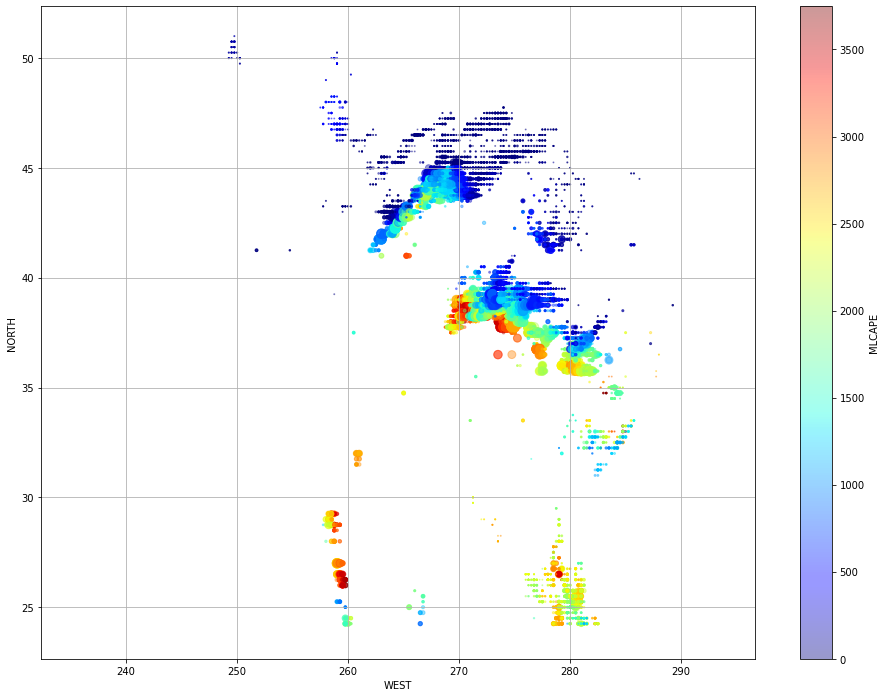

In [8]:
# make a copy
ps_fitted = ps_df.copy()
# using the GeoDataFrame.geometry
ps_geometry: GeoSeries = ps_fitted["geometry"]
# set grid coordinates W,E
ps_fitted[["WEST", "EAST"]] = index_abs_argmin(ps_geometry.bounds[["minx", "maxx"]] % 360, GALWEM.geo.lon)
# and S,N
ps_fitted[["SOUTH", "NORTH"]] = index_abs_argmin(ps_geometry.bounds[["miny", "maxy"]], GALWEM.geo.lat)
# we can now drop the geometry and append our grid points to the index
ps_fitted = ps_fitted.drop(["geometry"], axis=1).set_index(["WEST", "EAST", "NORTH", "SOUTH"], append=True)
ps_fitted.reset_index(["WEST", "EAST"])[["WEST", "EAST"]].max()
import matplotlib.pyplot as plt

# idx: slice = pd.IndexSlice


# PROBSEVERE = pd.DataFrame(index=GALWEM.index, columns=ps_meshed.columns).fillna(0)

# PROBSEVERE.loc[ps_meshed.index, :] = ps_meshed


# assert all(PROBSEVERE.index == GALWEM.index)


plt.rcParams["axes.grid"] = True
fig, ax = plt.subplots()
# PROBSEVERE.reset_index(["lat", "lon"]).plot(
#     kind="scatter",
#     x="lon",
#     y="lat",
# s="PS",
# c="MLCAPE",
# ax=ax,
# figsize=(16, 12),
# cmap=plt.get_cmap("jet"),
# alpha=0.4,

# the probsevere polloygon have been fitted to the grid
ps_fitted
ps_fitted.reset_index(["WEST", "EAST", "NORTH", "SOUTH"]).astype(float).plot(
    kind="scatter",
    x="WEST",
    y="NORTH",
    s="PS",
    c="MLCAPE",
    ax=ax,
    figsize=(16, 12),
    cmap=plt.get_cmap("jet"),
    alpha=0.4,
)

# data prep: sync time & grid
the association of probsevere data has been made to the galwem grid, but the valid times dont line up.

we could just look for values nearest to the galwem 3 hour interval and drop everything else, but lets try and weight the values based on the delta from the valid time

### PREP FINAL: time and grid sync

<class 'numpy.datetime64'>
<class 'numpy.datetime64'>
<class 'numpy.datetime64'>


<AxesSubplot:xlabel='lon', ylabel='lat'>

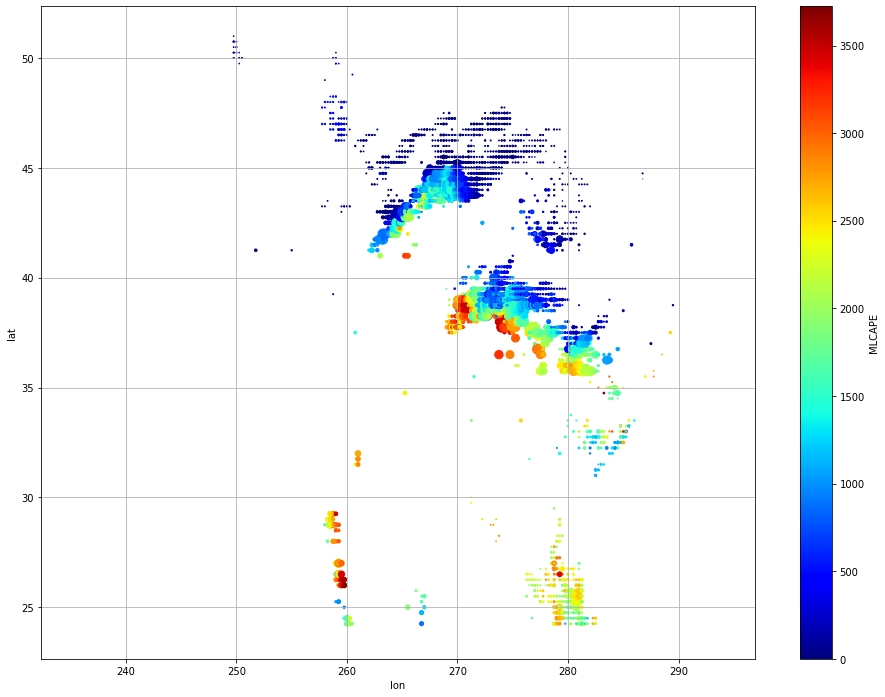

In [9]:
ps_validtimes = ps_fitted.index.unique("validTime")
galwem_validtimes = galwem_timestamp_filepath.index.values

# the grid now has to be synced as its possible
# to have the same value for for the same grid point
#
# -----------------------------------------
# |                   |                   |
# |                   |                   |
# |                   |                   |
# |                   |                   |
# |                   |                   |
# |                se | sw                |
# -----------------------------------------
# |                ne | nw                |
# |                   |                   |
# |                   |                   |
# |                   |                   |
# |                   |                   |
# |                   |                   |
# -----------------------------------------


def itertime(
    source: pd.Index,
    target: np.ndarray,
) -> Iterable[tuple[pd.Timestamp, pd.Index]]:
    time_interval = len(target)
    start_time = np.argmin(
        abs(target[:, np.newaxis] - source.values) > pd.to_timedelta(time_interval, unit="h"),
        axis=1,
    )

    end_time = np.roll(start_time, -1)
    end_time[-1] = -1

    for timestamp, tuple_slice in zip(target, zip(start_time, end_time)):
        yield timestamp, source[slice(*tuple_slice)]


def synctime_meshgrid(source: pd.DataFrame) -> pd.DataFrame:
    source = source.droplevel("ID").astype(np.float32)

    def generate():
        for galwem_valid_hour, ps_time_index in itertime(ps_validtimes, galwem_validtimes):
            frame = source.loc[ps_time_index, :].groupby(["WEST", "EAST", "NORTH", "SOUTH"]).mean()

            index_names = frame.index.names

            west, east, north, south = (frame.index.get_level_values(name) for name in index_names)

            mesh_grid_condition = (north == south) & (west == east)
            # NOTE NEEDS VALIDATION
            frame.loc[mesh_grid_condition] = frame.loc[mesh_grid_condition].groupby(index_names).mean()

            frame = frame.droplevel(["WEST", "SOUTH"])

            frame.index = frame.index.set_names(["lon", "lat"])
            print(type(galwem_valid_hour))
            frame["validTime"] = galwem_valid_hour.astype(int)

            yield frame.reset_index().set_index(["validTime", "lat", "lon"], append=True)

    return pd.concat(generate(), axis=0).droplevel(0)


plt.rcParams["axes.grid"] = True
fig, ax = plt.subplots()

ps_meshed = synctime_meshgrid(ps_fitted)
ps_meshed.reset_index(["lat", "lon"]).astype(float).plot(
    kind="scatter",
    c="MLCAPE",
    s="PS",
    x="lon",
    ax=ax,
    y="lat",
    figsize=(16, 12),
    cmap=plt.get_cmap("jet"),
)
# ps_meshed.index[ps_meshed.index.name == "validTime"]/
# def indexer(index: pd.Index, *args):
#     return pd.Index([index.get_level_values(arg) for arg in args], dtype=np.float32)


# ps_meshed.loc[indexer(ps_meshed.index, "lat", "lon")]
# ps_meshed.loc[]  # [("validTime", "lat", "lon"), :].index
# np.stack(ps_meshed.loc[].index)
# ps_meshed.index.names =="validTime"
# dir(ps_meshed.index.names)  # "validTime"
# .plot(

#     s="PS",
#     c="MLCAPE",
#     ax=ax,
#     figsize=(16, 12),
#     cmap=plt.get_cmap("jet"),
#     alpha=0.4,
# )

elements                         MUCAPE  MLCAPE  MLCIN  EBSHEAR  SRH01KM  \
validTime           lat  lon                                               
1653004800000000000 20.0 230.00     0.0     0.0    0.0      0.0      0.0   
                         230.25     0.0     0.0    0.0      0.0      0.0   
                         230.50     0.0     0.0    0.0      0.0      0.0   
                         230.75     0.0     0.0    0.0      0.0      0.0   
                         231.00     0.0     0.0    0.0      0.0      0.0   
...                                 ...     ...    ...      ...      ...   
1653026400000000000 55.0 299.00     0.0     0.0    0.0      0.0      0.0   
                         299.25     0.0     0.0    0.0      0.0      0.0   
                         299.50     0.0     0.0    0.0      0.0      0.0   
                         299.75     0.0     0.0    0.0      0.0      0.0   
                         300.00     0.0     0.0    0.0      0.0      0.0   

elements                         MEANWIND_1-3kmAGL  MESH  VIL_DENSITY  \
validTime           lat  lon                                            
1653004800000000000 20.0 230.00                0.0   0.0          0.0   
                         230.25                0.0   0.0          0.0   
                         230.50                0.0   0.0          0.0   
                         230.75                0.0   0.0          0.0   
                         231.00                0.0   0.0          0.0   
...                                            ...   ...          ...   
1653026400000000000 55.0 299.00                0.0   0.0          0.0   
                         299.25                0.0   0.0          0.0   
                         299.50                0.0   0.0          0.0   
                         299.75                0.0   0.0          0.0   
                         300.00                0.0   0.0          0.0   

elements                         FLASH_RATE  FLASH_DENSITY  ...  MAXRC_ICECF  \
validTime           lat  lon                                ...                
1653004800000000000 20.0 230.00         0.0            0.0  ...          0.0   
                         230.25         0.0            0.0  ...          0.0   
                         230.50         0.0            0.0  ...          0.0   
                         230.75         0.0            0.0  ...          0.0   
                         231.00         0.0            0.0  ...          0.0   
...                                     ...            ...  ...          ...   
1653026400000000000 55.0 299.00         0.0            0.0  ...          0.0   
                         299.25         0.0            0.0  ...          0.0   
                         299.50         0.0            0.0  ...          0.0   
                         299.75         0.0            0.0  ...          0.0   
                         300.00         0.0            0.0  ...          0.0   

elements                         WETBULB_0C_HGT  PWAT  CAPE_M10M30  LJA  SIZE  \
validTime           lat  lon                                                    
1653004800000000000 20.0 230.00             0.0   0.0          0.0  0.0   0.0   
                         230.25             0.0   0.0          0.0  0.0   0.0   
                         230.50             0.0   0.0          0.0  0.0   0.0   
                         230.75             0.0   0.0          0.0  0.0   0.0   
                         231.00             0.0   0.0          0.0  0.0   0.0   
...                                         ...   ...          ...  ...   ...   
1653026400000000000 55.0 299.00             0.0   0.0          0.0  0.0   0.0   
                         299.25             0.0   0.0          0.0  0.0   0.0   
                         299.50             0.0   0.0          0.0  0.0   0.0   
                         299.75             0.0   0.0          0.0  0.0   0.0   
                         300.00             0.0 

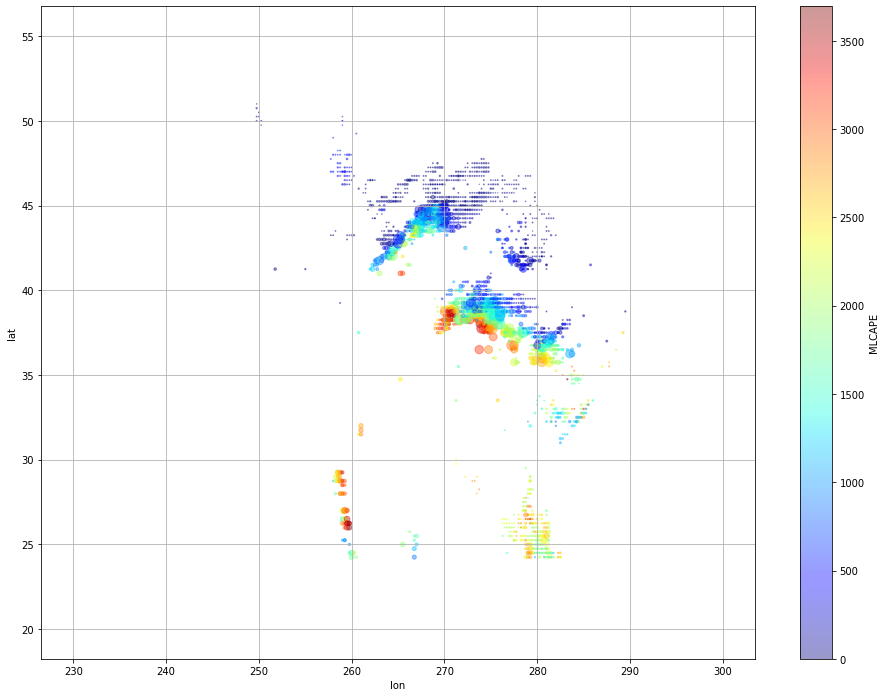

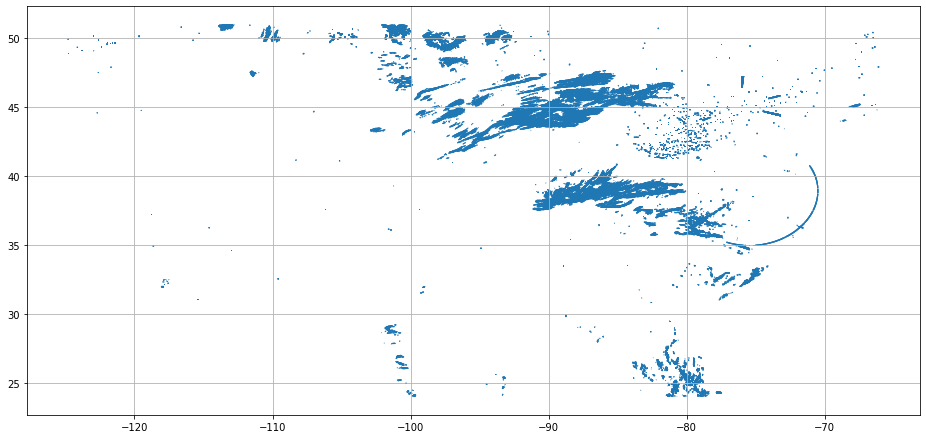

In [10]:
import matplotlib.pyplot as plt

idx: slice = pd.IndexSlice


PROBSEVERE = pd.DataFrame(index=GALWEM.index, columns=ps_meshed.columns).fillna(0)

PROBSEVERE.loc[ps_meshed.index, :] = ps_meshed


assert all(PROBSEVERE.index == GALWEM.index)


plt.rcParams["axes.grid"] = True
fig, ax = plt.subplots()
PROBSEVERE.reset_index(["lat", "lon"]).plot(
    kind="scatter",
    x="lon",
    y="lat",
    s="PS",
    c="MLCAPE",
    ax=ax,
    figsize=(16, 12),
    cmap=plt.get_cmap("jet"),
    alpha=0.4,
)
ps_df.plot(
    figsize=(16, 12),
)
PROBSEVERE

In [11]:
valid_times = 3
single_time_gridpoints = 39621
combined_time_gridpoints = 118863
assert single_time_gridpoints * valid_times == combined_time_gridpoints == GALWEM.shape[0] == PROBSEVERE.shape[0]
GALWEM.shape, PROBSEVERE.shape

((118863, 39), (118863, 24))